In [1]:
from PIL import Image, ImageDraw, ImageFilter
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Convolution2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout
from keras import optimizers
from tqdm import tqdm
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (8,6)

Using TensorFlow backend.


In [70]:
backgrounds_folder='../data/backgrounds'
signs_folder='../data/signs'
backgrounds=list(filter(lambda x: x[0] != '.', os.listdir(backgrounds_folder)))
signs=list(filter(lambda x: x[0] != '.', os.listdir(signs_folder)))
backgrounds=[Image.open(backgrounds_folder+'/'+backgrounds[i]) for i in range(len(backgrounds))]
signs=[Image.open(signs_folder+'/'+signs[i]) for i in range(len(signs))]
print(len(backgrounds), ' backgrounds')
print(len(signs), ' signs')

9  backgrounds
6  signs


### Generate data

In [34]:
canvas_size=(300,300)
sign_size_min=50
sign_size_max=150

In [76]:
NUM_IMAGES=2000
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for i in tqdm(range(NUM_IMAGES)):
    #pick random sign
    sign_index=random.randint(0,len(signs)-1)
    sign=signs[sign_index]
    size=random.randint(sign_size_min,sign_size_max)
    sign=sign.resize((size,size))
    #pick random background
    background_index=random.randint(0,len(backgrounds)-1)
    background=backgrounds[background_index]
    background=background.resize(canvas_size)

    top_left_x=random.randint(0,background.size[0]-sign.size[0])
    top_left_y=random.randint(0,background.size[1]-sign.size[1])
    background.paste(sign, (top_left_x, top_left_y),mask=sign)
    label=[top_left_x, top_left_y,top_left_x+sign.size[0], top_left_y+sign.size[1]]
    if i <0.9*NUM_IMAGES:
        x_train+=[np.array(background)]
        y_train+=[label]
    else:
        x_test+=[np.array(background)]
        y_test+=[label]

100%|██████████| 2000/2000 [00:55<00:00, 35.76it/s]


In [77]:
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [78]:
#Normalization
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 
y_train = y_train.astype('float32')/max(canvas_size)
y_test = y_test.astype('float32')/max(canvas_size)

In [79]:
def plot(X,Y):
    plt.imshow(X)
    p=2*max(canvas_size)/100
    plt.scatter([Y[0]-p,Y[2]+p,Y[0]-p,Y[2]+p],\
                [Y[1]-p,Y[3]+p,Y[3]+p,Y[1]-p],c='red')
    ax = plt.gca()
    ax.add_patch(patches.Rectangle((Y[0]-p,Y[1]-p),Y[2]-Y[0]+2*p,Y[3]-Y[1]+2*p,linewidth=2,edgecolor='r',facecolor='none'))
    return plt

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

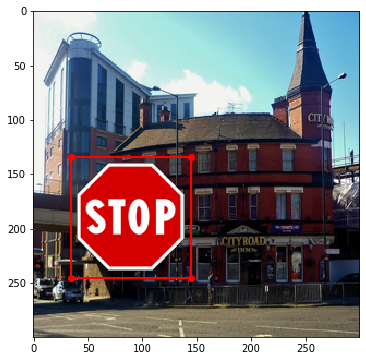

In [80]:
plot(x_train[1],y_train[1]*max(canvas_size))

### Define and train model

In [81]:
model = Sequential()
model.add(MaxPooling2D(pool_size=(2,2),input_shape=(canvas_size[1], canvas_size[0],3)))
model.add(Convolution2D(20, (3,3),activation='relu'))
model.add(Convolution2D(15, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(10, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(4,activation='relu'))
model.build()

In [82]:
model.compile(optimizer='adam',loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)

In [83]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_20 (MaxPooling (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 148, 148, 20)      560       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 146, 146, 15)      2715      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 73, 73, 15)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 71, 71, 10)        1360      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 35, 35, 10)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 12250)            

In [84]:
history=model.fit(x_train, y_train, epochs=10,
                  validation_split=0.1, shuffle=True,
                  verbose=1,callbacks=[es])

Train on 1620 samples, validate on 180 samples
Epoch 1/100
1620/1620 [==============================] - 40s 25ms/step - loss: 0.0384 - val_loss: 0.0123
Epoch 2/100
1620/1620 [==============================] - 45s 28ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 3/100
1620/1620 [==============================] - 39s 24ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 4/100
1620/1620 [==============================] - 37s 23ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 5/100
1620/1620 [==============================] - 40s 25ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 6/100
1620/1620 [==============================] - 40s 25ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 7/100
1620/1620 [==============================] - 35s 22ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 8/100
1620/1620 [==============================] - 35s 22ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 9/100
1620/1620 [==============================] - 38s 23ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 10

### Evaluate on generated test set

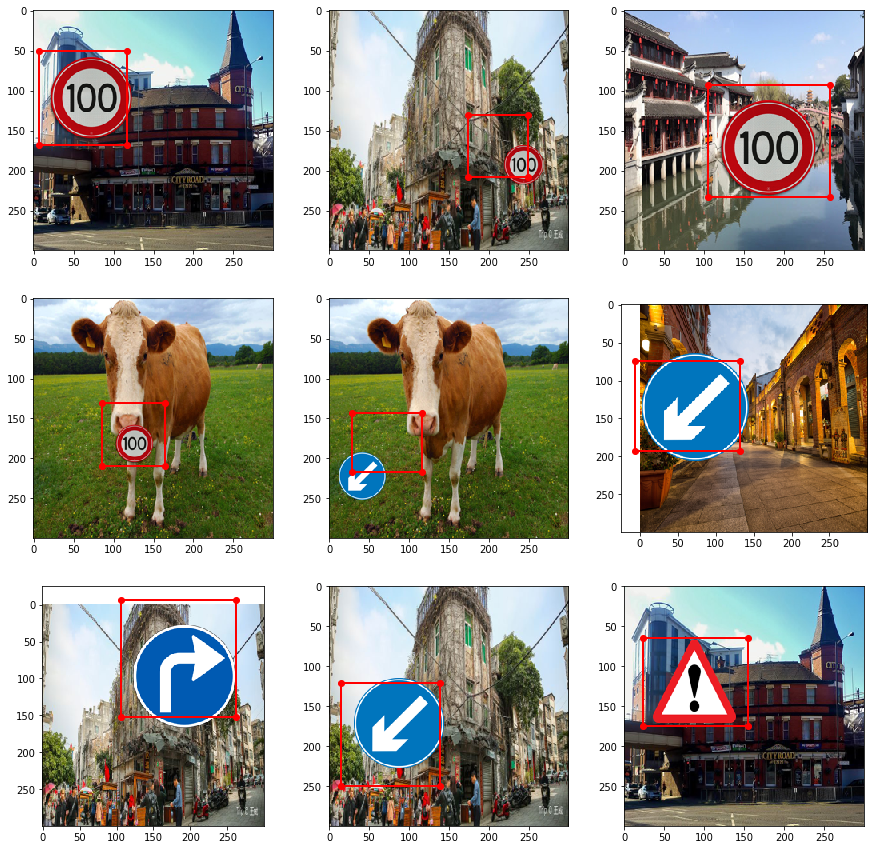

In [85]:
plt.figure(figsize=(15,15))
for i in range(9):
    ax= plt.subplot(3,3,i+1)
    k = random.randint(0,len(x_test))-1
    x=x_test[k]
    y=model.predict(np.array([x]))[0]
    im=plot(x,y*max(canvas_size))
    #plt.title(i)

### Evaluate on simple, but real test set

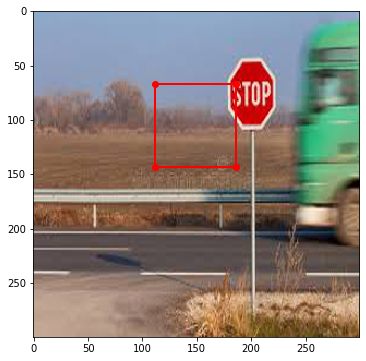

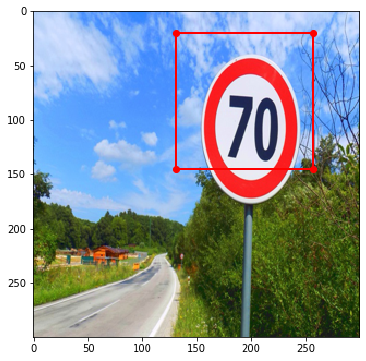

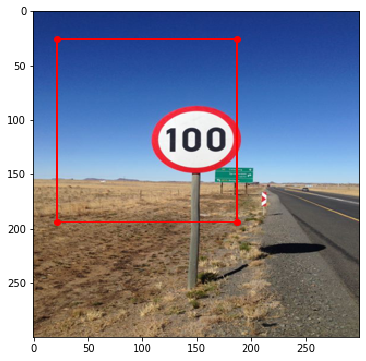

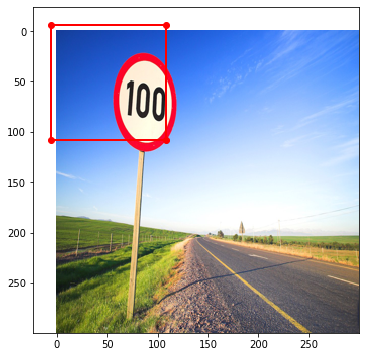

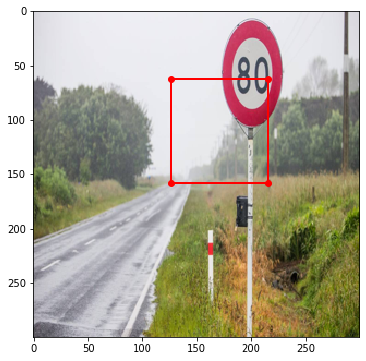

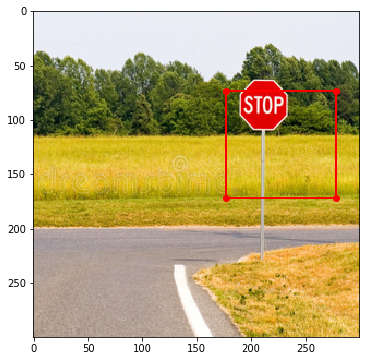

In [86]:
test_folder='../data/test'
test_images=list(filter(lambda x: x[0] != '.', os.listdir(test_folder)))
for i in range(len(test_images)):
    x=Image.open(test_folder+'/'+test_images[i]).resize(canvas_size)
    x=np.array(x)/255
    y=model.predict(np.array([x]))[0]
    im=plot(x,y*max(canvas_size))
    plt.show()

In [87]:
model.save('./model.weights')